In [1]:
%cd /Users/yantong/Desktop/NLP\ for\ Risk/Code/

/Users/yantong/Desktop/NLP for Risk/Code


## Import Libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [4]:
import jieba as jb
import re

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Sequential


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
 
from sklearn.model_selection import cross_val_score


In [7]:
from sklearn.model_selection import GridSearchCV


In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth",None)
pd.set_option('display.width',None)

In [9]:
import json

## Read Data

In [37]:
split_data = pd.read_csv('split.csv')

In [38]:
split_data = split_data.drop(['Unnamed: 0'],axis = 1)

In [39]:
c = [1012,956,1835]
split_data = split_data.drop(c)
split_data = split_data.reset_index()

## Data Preparation

In [40]:
seg_data = split_data[['cleaned_content','baidu_seg','baidu_prob']]

In [41]:
seg_data_tran = seg_data.copy()

In [42]:
seg_data_tran['baidu_seg'] = seg_data_tran['baidu_seg'].apply(lambda row: eval(row))
seg_data_tran['baidu_prob'] = seg_data_tran['baidu_prob'].apply(lambda row: eval(row))

In [43]:
seg = []
prob = []
content = []
for row_idx in range(seg_data_tran.shape[0]):
    row_seg = seg_data_tran.loc[row_idx,'baidu_seg']
    row_prob = seg_data_tran.loc[row_idx,'baidu_prob']
    row_content = seg_data_tran.loc[row_idx,'cleaned_content']
    list_num = len(row_seg)
    for j in range(list_num):
        content.append(row_content)
        seg.append(row_seg[j])
        prob.append(row_prob[j])
        

In [44]:
newvalues = pd.DataFrame()
newvalues['content'] = content
newvalues['baidu_seg'] = seg
newvalues['baidu_prob'] = prob

In [45]:
newvalues['label'] = newvalues['baidu_prob'].apply(lambda row: 1 if row>0.5 else 0)

In [46]:
newvalues.label.value_counts()

0    29727
1    11879
Name: label, dtype: int64

#### 统计segmentation字数

In [47]:
len(''.join(newvalues.loc[19852,'baidu_seg']))

498

In [48]:
newvalues['word_counts'] = newvalues.baidu_seg.apply(lambda row: len(''.join(row)))

<AxesSubplot:>

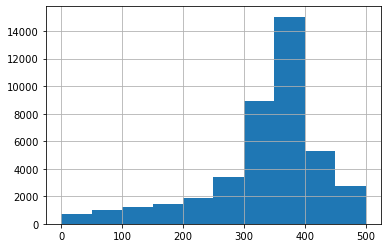

In [49]:
newvalues.word_counts.hist()

In [50]:
newvalues[newvalues.word_counts <= 20].shape

(219, 5)

In [51]:
newvalues = newvalues[newvalues.word_counts >250]
newvalues = newvalues.reset_index()

In [52]:
#c = [3245,5861,5863,6678,6681,10257]

In [53]:
#newvalues = newvalues.drop(c)

In [54]:
newvalues = newvalues.drop(['index'],axis = 1)

In [55]:
#newvalues.loc[10257]

In [56]:
for i in range(newvalues.shape[0]):
    if len(newvalues.loc[i,'baidu_seg']) == 20:
        print(i)

19852


In [57]:
newvalues.loc[19852,'baidu_prob']

0.0951973

In [58]:
newvalues.loc[19852,'baidu_seg']

['Additional',
 'Guidance',
 'on',
 'A',
 'septic',
 'Processing',
 '无菌',
 '加工',
 '指南',
 'SeeFDA’sguidancedocumentSterileDrugProductsProducedbyAsepticProcessing—CurrentGoodManufacturingPracticetohelpyoumeettheCGMPrequirementswhenmanufacturingsteriledrugsusingasepticprocessingathttps://www.fda.gov/media/71026/download.',
 '参见',
 'FDA',
 '指南',
 '文件',
 '无菌',
 '工艺',
 '生产',
 '无菌',
 '药品',
 'CGMP']

In [94]:
# 19852,28322
newvalues = newvalues.drop(28322)

In [95]:
newvalues = newvalues.reset_index()

## Imbalanced

In [96]:
from collections import Counter
Counter(newvalues.label)

Counter({0: 24819, 1: 10544})

### Resampling -- Oversampling

In [97]:
X = np.array(newvalues.baidu_seg).reshape(-1,1)
y = newvalues.label

#### Naive Ramdom Over-sampling

In [98]:
from imblearn.over_sampling import RandomOverSampler

In [99]:
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X, y)

In [100]:
X = newvalues['baidu_seg']
y = newvalues['label']

## Modelling

### Model 1.1: TF-IDF + CNN

In [101]:
import kashgari
from kashgari import utils
from kashgari.embeddings import BertEmbedding
from kashgari.tasks.labeling import BiLSTM_CRF_Model
# from data_load import DataReader

In [65]:
from sklearn.model_selection import train_test_split


In [66]:
from tensorflow.keras.callbacks import TensorBoard
from kashgari.tasks.classification import CNN_Model

In [67]:
#from sklearn.feature_extraction.text import TfidfVectorizer
 
#tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
#vectorizer = CountVectorizer()    
#features = tfidf.fit_transform(vectorizer.fit_transform(labeled_data_3.content_cut))
#labels = labeled_data_3.label
#print(features.shape)
#print('-----------------------------')
#print(features)
#print(labels)

In [68]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, 
                                                                                 newvalues.index, 
                                                                                 test_size=0.2, stratify=y, random_state=0)
X_test = X_test.tolist()
y_test = y_test.tolist()



X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train, y_train, 
                                                                                 indices_train, 
                                                                                 test_size=0.05, stratify=y_train, random_state=0)

X_train = X_train.tolist()
y_train = y_train.tolist()
X_val = X_val.tolist()
y_val = y_val.tolist()



In [69]:
# Using TensorBoard record training process
tf_board = TensorBoard(log_dir='tf_dir/cnn_model_split',
                       histogram_freq=5,
                       update_freq='batch')


In [70]:
model = CNN_Model()
model.fit(X_train, y_train, X_val, y_val,
          batch_size=128,
          callbacks=[tf_board])

Preparing text vocab dict: 100%|██████████| 1415/1415 [00:00<00:00, 17272.52it/s]
2020-12-30 10:11:35,745 [DEBUG] kashgari - --- Build vocab dict finished, Total: 67846 ---
2020-12-30 10:11:35,746 [DEBUG] kashgari - Top-10: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', ';', 'amp', '项目', '工程', '企业', '施工']
Calculating sequence length: 100%|██████████| 1415/1415 [00:00<00:00, 683591.36it/s]
2020-12-30 10:11:35,908 [DEBUG] kashgari - Calculated sequence length = 220
2020-12-30 10:11:35,961 [DEBUG] kashgari - Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
layer_embedding (Embedding)  (None, None, 100)         6784600   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         64128     
____________________

Epoch 1/5
209/209 [==============================] - 24s 111ms/step - loss: 0.4913 - accuracy: 0.7579 - val_loss: 0.3027 - val_accuracy: 0.8693
Epoch 2/5
209/209 [==============================] - 23s 109ms/step - loss: 0.2134 - accuracy: 0.9107 - val_loss: 0.3387 - val_accuracy: 0.8665
Epoch 3/5
209/209 [==============================] - 23s 110ms/step - loss: 0.0546 - accuracy: 0.9841 - val_loss: 0.3904 - val_accuracy: 0.8729
Epoch 4/5
209/209 [==============================] - 23s 112ms/step - loss: 0.0142 - accuracy: 0.9971 - val_loss: 0.4311 - val_accuracy: 0.8693
Epoch 5/5
209/209 [==============================] - 23s 110ms/step - loss: 0.0080 - accuracy: 0.9984 - val_loss: 0.4891 - val_accuracy: 0.8750


In [71]:
import os
import joblib
os.chdir("saved_model_split")
model.save('tfidf_cnn')

2020-12-30 10:13:33,097 [INFO] kashgari - model saved to /Users/yantong/Desktop/NLP for Risk/Code/saved_model_split/tfidf_cnn


'/Users/yantong/Desktop/NLP for Risk/Code/saved_model_split/tfidf_cnn'

In [72]:
os.chdir("..")

In [73]:
model.evaluate(X_test, y_test)

2020-12-30 10:13:33,111 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 279
2020-12-30 10:13:33,847 [DEBUG] kashgari - predict input shape (7073, 279) x: 
[[   2    5    4 ...    0    0    0]
 [   2 1280 4530 ...    0    0    0]
 [   2  494 6847 ...    0    0    0]
 ...
 [   2 2165    4 ...    0    0    0]
 [   2    6 1121 ...    0    0    0]
 [   2 1057 4973 ...    0    0    0]]
2020-12-30 10:13:35,360 [DEBUG] kashgari - predict output shape (7073, 2)
2020-12-30 10:13:35,365 [DEBUG] kashgari - predict output argmax: [0 1 0 ... 0 0 0]


              precision    recall  f1-score   support

           0     0.8747    0.9519    0.9116      4964
           1     0.8570    0.6790    0.7577      2109

    accuracy                         0.8705      7073
   macro avg     0.8658    0.8154    0.8347      7073
weighted avg     0.8694    0.8705    0.8657      7073



{'detail': {'0': {'precision': 0.8746760459089227,
   'recall': 0.951853344077357,
   'f1-score': 0.9116341886938067,
   'support': 4964},
  '1': {'precision': 0.8569718731298623,
   'recall': 0.6789947842579421,
   'f1-score': 0.7576719576719577,
   'support': 2109},
  'accuracy': 0.8704934257033791,
  'macro avg': {'precision': 0.8658239595193925,
   'recall': 0.8154240641676496,
   'f1-score': 0.8346530731828823,
   'support': 7073},
  'weighted avg': {'precision': 0.8693970836028238,
   'recall': 0.8704934257033791,
   'f1-score': 0.8657263214203613,
   'support': 7073}},
 'precision': 0.8693970836028238,
 'recall': 0.8704934257033791,
 'f1-score': 0.8657263214203613,
 'support': 7073}

### Model 1.2: TF-IDF + CNN + Naive Random Sampling

In [74]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, 
                                                                                 newvalues.index, 
                                                                                 test_size=0.2, stratify=y, random_state=0)
X_test = X_test.tolist()
y_test = y_test.tolist()

X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train, y_train, 
                                                                                 indices_train, 
                                                                                 test_size=0.05, stratify=y_train, random_state=0)

X_train = X_train.tolist()
y_train = y_train.tolist()
X_val = X_val.tolist()
y_val = y_val.tolist()

In [77]:
X_resampling = np.array(X_train).reshape(-1,1)
y_resampling = y_train
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [78]:
# Using TensorBoard record training process
tf_board = TensorBoard(log_dir='tf_dir/cnn_model_naive_resampling_split',
                       histogram_freq=5,
                       update_freq='batch')


In [79]:
model = CNN_Model()
model.fit(X_train, y_train, X_val, y_val,
          batch_size=128,
          callbacks=[tf_board])

Preparing text vocab dict: 100%|██████████| 1415/1415 [00:00<00:00, 17103.87it/s]
2020-12-30 10:14:10,119 [DEBUG] kashgari - --- Build vocab dict finished, Total: 67846 ---
2020-12-30 10:14:10,120 [DEBUG] kashgari - Top-10: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', ';', 'amp', '项目', '工程', '企业', '施工']
Calculating sequence length: 100%|██████████| 1415/1415 [00:00<00:00, 1022384.18it/s]
2020-12-30 10:14:10,269 [DEBUG] kashgari - Calculated sequence length = 220
2020-12-30 10:14:10,315 [DEBUG] kashgari - Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
layer_embedding (Embedding)  (None, None, 100)         6784600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         64128     
___________________

Epoch 1/5
209/209 [==============================] - 23s 109ms/step - loss: 0.5124 - accuracy: 0.7329 - val_loss: 0.3181 - val_accuracy: 0.8572
Epoch 2/5
209/209 [==============================] - 23s 108ms/step - loss: 0.2348 - accuracy: 0.9002 - val_loss: 0.3312 - val_accuracy: 0.8636
Epoch 3/5
209/209 [==============================] - 24s 116ms/step - loss: 0.0723 - accuracy: 0.9773 - val_loss: 0.4113 - val_accuracy: 0.8679
Epoch 4/5
209/209 [==============================] - 25s 122ms/step - loss: 0.0175 - accuracy: 0.9958 - val_loss: 0.4478 - val_accuracy: 0.8686
Epoch 5/5
209/209 [==============================] - 23s 110ms/step - loss: 0.0078 - accuracy: 0.9986 - val_loss: 0.4855 - val_accuracy: 0.8679


In [80]:
import os
import joblib
os.chdir("saved_model_split")
model.save('tfidf_cnn_naive_resampling')

2020-12-30 10:16:09,565 [INFO] kashgari - model saved to /Users/yantong/Desktop/NLP for Risk/Code/saved_model_split/tfidf_cnn_naive_resampling


'/Users/yantong/Desktop/NLP for Risk/Code/saved_model_split/tfidf_cnn_naive_resampling'

In [81]:
os.chdir("..")

In [82]:
model.evaluate(X_test, y_test)

2020-12-30 10:16:09,585 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 279
2020-12-30 10:16:10,125 [DEBUG] kashgari - predict input shape (7073, 279) x: 
[[   2    5    4 ...    0    0    0]
 [   2 1280 4530 ...    0    0    0]
 [   2  494 6847 ...    0    0    0]
 ...
 [   2 2165    4 ...    0    0    0]
 [   2    6 1121 ...    0    0    0]
 [   2 1057 4973 ...    0    0    0]]
2020-12-30 10:16:11,623 [DEBUG] kashgari - predict output shape (7073, 2)
2020-12-30 10:16:11,628 [DEBUG] kashgari - predict output argmax: [0 1 0 ... 0 0 0]


              precision    recall  f1-score   support

           0     0.8971    0.9154    0.9062      4964
           1     0.7908    0.7530    0.7714      2109

    accuracy                         0.8670      7073
   macro avg     0.8440    0.8342    0.8388      7073
weighted avg     0.8654    0.8670    0.8660      7073



{'detail': {'0': {'precision': 0.897137216189536,
   'recall': 0.9153908138597905,
   'f1-score': 0.9061721009073687,
   'support': 4964},
  '1': {'precision': 0.7908366533864541,
   'recall': 0.752963489805595,
   'f1-score': 0.7714355112946321,
   'support': 2109},
  'accuracy': 0.866958857627598,
  'macro avg': {'precision': 0.8439869347879951,
   'recall': 0.8341771518326928,
   'f1-score': 0.8388038061010004,
   'support': 7073},
  'weighted avg': {'precision': 0.8654409222616836,
   'recall': 0.866958857627598,
   'f1-score': 0.8659968616180626,
   'support': 7073}},
 'precision': 0.8654409222616836,
 'recall': 0.866958857627598,
 'f1-score': 0.8659968616180626,
 'support': 7073}

### Model 2.1: 现有样本训练Word2Vec + LR

In [102]:
with open('./stopwords.txt', encoding='utf8') as file:
    line_list = file.readlines()
    stopword_list = [k.strip() for k in line_list]
    stopword_set = set(stopword_list)
    print('停顿词列表，即变量stopword_list中共有%d个元素' %len(stopword_list))
    print('停顿词集合，即变量stopword_set中共有%d个元素' %len(stopword_set))

停顿词列表，即变量stopword_list中共有778个元素
停顿词集合，即变量stopword_set中共有778个元素


In [103]:
#cutWords_List = []
#startTime = time.time()
#content_series = newvalues['baidu_seg']
#for i in range(len(content_series)):
#    content = content_series.iloc[i]
#    cutWords = [k for k in content]
#    if (i + 1) % 3000 == 0:
#        usedTime = time.time() - startTime
#        print('前%d篇文章分词共花费%.2f秒' %(i+1, usedTime))
#    cutWords_list.append(cutWords)

In [104]:
cutWords_list = newvalues['baidu_seg']

In [105]:
import time
from gensim.models import Word2Vec
startTime = time.time()
word2vec_model = Word2Vec(cutWords_list, size=200, iter=10, min_count=20)
usedTime = time.time() - startTime
print('形成word2vec模型共花费%.2f秒' %usedTime)

形成word2vec模型共花费43.09秒


In [106]:
import warnings
warnings.filterwarnings('ignore')

In [107]:
word2vec_model.wv.most_similar('建筑')
# word2vec_model.similarity('治愈','感染')

[('建筑工程', 0.5852578282356262),
 ('市政工程', 0.45775464177131653),
 ('装配式建筑', 0.4472390413284302),
 ('修缮', 0.43000537157058716),
 ('建筑业', 0.41388386487960815),
 ('建筑类', 0.41131076216697693),
 ('建造', 0.38067078590393066),
 ('装修', 0.3663729131221771),
 ('建筑设计', 0.36396342515945435),
 ('工程造价', 0.35552978515625)]

#### Word2Vec 

In [108]:
import numpy as np

def get_contentVector(cutWords, word2vec_model):
    vector_list = [word2vec_model.wv[k] for k in cutWords if k in word2vec_model]
    contentVector = np.array(vector_list).mean(axis=0)
    return contentVector

In [109]:
import time

startTime = time.time()
contentVector_list = []
for i in range(len(cutWords_list)):
    cutWords = cutWords_list[i]
#    if (i+1) % 3000 == 0:
#        usedTime = time.time() - startTime
#        print('前%d篇文章内容表示成向量共花费%.2f秒' %(i+1, usedTime))
    contentVector_list.append(list(get_contentVector(cutWords, word2vec_model)))
X = np.array(contentVector_list)

In [110]:
X.shape # check

(35363, 200)

#### Logistic Regression Models

In [112]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(newvalues['label'])

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [115]:
X = np.array(X)

In [116]:
train_X_lr, test_X_lr, train_y_lr, test_y_lr = train_test_split(X, y, test_size=0.2)

In [117]:
logisticRegression_model = LogisticRegression()
logisticRegression_model.fit(train_X_lr, train_y_lr)
logisticRegression_model.score(test_X_lr, test_y_lr)

0.8604552523681606

In [118]:
y_pred_lr = logisticRegression_model.predict(test_X_lr)

In [119]:
print(classification_report(test_y_lr, y_pred_lr,digits=4))

              precision    recall  f1-score   support

           0     0.8868    0.9184    0.9023      4964
           1     0.7904    0.7240    0.7558      2109

    accuracy                         0.8605      7073
   macro avg     0.8386    0.8212    0.8290      7073
weighted avg     0.8580    0.8605    0.8586      7073



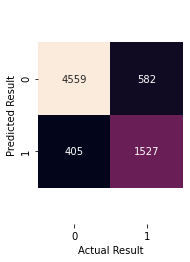

In [120]:
mat = confusion_matrix( y_pred_lr,test_y_lr)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [121]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [122]:
predslog = logisticRegression_model.predict_proba(test_X_lr)[:,1]
metrics.roc_auc_score(test_y_lr,predslog, average='macro', sample_weight=None)

0.9226925088708879

In [123]:
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')

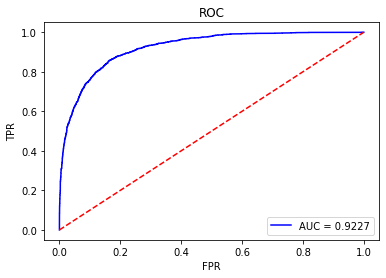

In [124]:
plot_roc(test_y_lr,predslog)

### Model 2.2: 现有样本训练Word2Vec + LR + Naive Resampling

In [125]:
X = newvalues['baidu_seg']
y = newvalues['label']

#### Word2Vec

In [126]:
cutWords_list = newvalues['baidu_seg']

startTime = time.time()
contentVector_list = []
for i in range(len(cutWords_list)):
    cutWords = cutWords_list[i]
#    if (i+1) % 3000 == 0:
#        usedTime = time.time() - startTime
#        print('前%d篇文章内容表示成向量共花费%.2f秒' %(i+1, usedTime))
    contentVector_list.append(list(get_contentVector(cutWords, word2vec_model)))
X = np.array(contentVector_list)

In [127]:
X = np.array(X)

In [128]:
train_X_lr, test_X_lr, train_y_lr, test_y_lr = train_test_split(X, y, test_size=0.2)

In [129]:
X_resampling = np.array(train_X_lr)
y_resampling = train_y_lr
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)

In [130]:
logisticRegression_model = LogisticRegression()
logisticRegression_model.fit(X_resampling, y_resampling)
logisticRegression_model.score(test_X_lr, test_y_lr)
#logisticRegression_model.score(X_resampling, y_resampling)

0.8608794005372543

In [131]:
y_pred_lr = logisticRegression_model.predict(test_X_lr)

In [132]:
print(classification_report(test_y_lr, y_pred_lr,digits=4))

              precision    recall  f1-score   support

           0     0.8850    0.9208    0.9026      4950
           1     0.7962    0.7211    0.7568      2123

    accuracy                         0.8609      7073
   macro avg     0.8406    0.8210    0.8297      7073
weighted avg     0.8584    0.8609    0.8588      7073



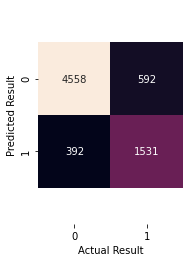

In [133]:
mat = confusion_matrix( y_pred_lr,test_y_lr)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [134]:
predslog = logisticRegression_model.predict_proba(test_X_lr)[:,1]
metrics.roc_auc_score(test_y_lr,predslog, average='macro', sample_weight=None)

0.9286124552163177

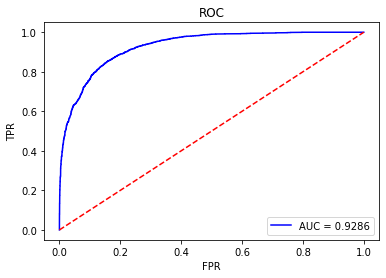

In [135]:
plot_roc(test_y_lr,predslog)

### Model 3.1: 现有样本训练Word2Vec + SVM

In [136]:
#训练模型
model_svm = LinearSVC()
train_X_svm, test_X_svm, train_y_svm, test_y_svm = train_test_split(X, y, test_size=0.2)


In [137]:
model_svm.fit(train_X_svm, train_y_svm)
y_pred_svm = model_svm.predict(test_X_svm)

In [138]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.8879    0.9240    0.9056      5025
           1     0.7928    0.7139    0.7513      2048

    accuracy                         0.8631      7073
   macro avg     0.8404    0.8189    0.8284      7073
weighted avg     0.8604    0.8631    0.8609      7073



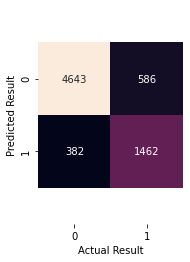

In [139]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

### Model 3.2 现有样本训练Word2Vec + SVM + Naive Resampling

In [146]:
X_resampling = np.array(train_X_svm)
y_resampling = train_y_svm
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)


In [147]:
model_svm_sampling.fit(X_resampled_naive, y_resampled_naive)
y_pred_svm = model_svm.predict(test_X_svm)

In [148]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.8917    0.9203    0.9058      4967
           1     0.7966    0.7365    0.7654      2106

    accuracy                         0.8655      7073
   macro avg     0.8442    0.8284    0.8356      7073
weighted avg     0.8634    0.8655    0.8640      7073



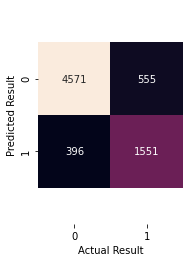

In [149]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

### Model 3.3 现有样本训练Word2Vec + kernal_SVM

In [ ]:
from sklearn.svm import SVC

#### SVC(kernel = 'poly', C = 0.1)

In [185]:
kernal_svm = SVC(kernel = 'poly', C = 0.1)
kernal_svm.fit(train_X_svm,train_y_svm)

SVC(C=0.1, kernel='poly')

In [186]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [187]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.8285    0.9530    0.8864      4974
           1     0.8269    0.5326    0.6479      2099

    accuracy                         0.8282      7073
   macro avg     0.8277    0.7428    0.7672      7073
weighted avg     0.8281    0.8282    0.8156      7073



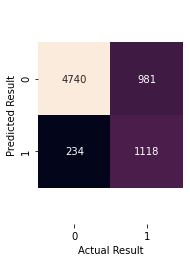

In [188]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

#### kernal_svm = SVC(kernel = 'poly', C = 1)

In [199]:
kernal_svm = SVC(kernel = 'poly', C = 1)
kernal_svm.fit(train_X_svm,train_y_svm)

SVC(C=1, kernel='poly')

In [200]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [183]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.8743    0.9355    0.9038      4974
           1     0.8167    0.6813    0.7429      2099

    accuracy                         0.8600      7073
   macro avg     0.8455    0.8084    0.8234      7073
weighted avg     0.8572    0.8600    0.8561      7073



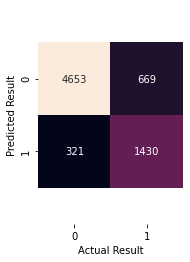

In [184]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

### Model 3.4 现有样本训练Word2Vec + kernal_SVM + Naive Resampling
可能是做了不平衡处理的原因，模型更偏向于预测样本为负类。不过也不算一件坏事。

In [162]:
X_resampling = np.array(train_X_svm)
y_resampling = train_y_svm
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)


#### kernal_svm = SVC(kernel = 'poly', C = 0.1)

In [173]:
kernal_svm = SVC(kernel = 'poly', C = 0.1)
kernal_svm.fit(X_resampled_naive,y_resampled_naive)

SVC(C=0.1, kernel='poly')

In [174]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [175]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9322    0.7994    0.8607      4974
           1     0.6446    0.8623    0.7377      2099

    accuracy                         0.8180      7073
   macro avg     0.7884    0.8308    0.7992      7073
weighted avg     0.8469    0.8180    0.8242      7073



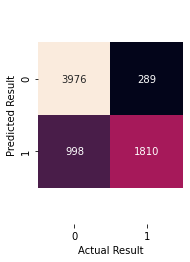

In [176]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

#### kernal_svm = SVC(kernel = 'poly', C = 1)


In [177]:
kernal_svm = SVC(kernel = 'poly', C = 1)
kernal_svm.fit(X_resampled_naive,y_resampled_naive)

SVC(C=1, kernel='poly')

In [178]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [179]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9311    0.8398    0.8831      4974
           1     0.6919    0.8528    0.7640      2099

    accuracy                         0.8436      7073
   macro avg     0.8115    0.8463    0.8235      7073
weighted avg     0.8601    0.8436    0.8477      7073



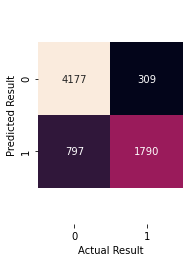

In [180]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

### Model 3.5 现有样本训练Word2Vec + RBF_SVM 


In [201]:
rbf_svm = SVC(C=1.0, kernel='rbf', gamma=0.1)
rbf_svm.fit(train_X_svm,train_y_svm)

SVC(gamma=0.1)

In [202]:
y_pred_svm = rbf_svm.predict(test_X_svm)

In [203]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.8879    0.9254    0.9063      4974
           1     0.8036    0.7232    0.7613      2099

    accuracy                         0.8654      7073
   macro avg     0.8458    0.8243    0.8338      7073
weighted avg     0.8629    0.8654    0.8633      7073



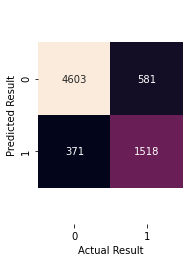

In [204]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

### Model 3.6 现有样本训练Word2Vec + RBF_SVM + Naive Resampling

In [205]:
rbf_svm = SVC(C=1.0, kernel='rbf', gamma=0.1)
rbf_svm.fit(X_resampled_naive,y_resampled_naive)

SVC(gamma=0.1)

In [206]:
y_pred_svm = rbf_svm.predict(test_X_svm)

In [207]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9226    0.8647    0.8927      4974
           1     0.7209    0.8280    0.7707      2099

    accuracy                         0.8538      7073
   macro avg     0.8217    0.8464    0.8317      7073
weighted avg     0.8627    0.8538    0.8565      7073



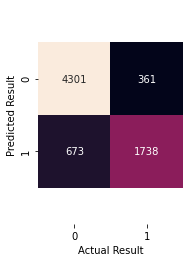

In [208]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

### Model 4.1 现有样本训练Word2Vec + XGBoost

In [220]:
import xgboost as xgb 

In [212]:
train_X_xgb = train_X_svm.copy()
test_X_xgb = test_X_svm.copy()
train_y_xgb = train_y_svm.copy()
test_y_xgb = test_y_svm.copy()


In [216]:
train_X_xgb.shape

(28290, 200)

In [245]:
params={
'booster':'gbtree', 
# 这里手写数字是0-9，是一个多类的问题，因此采用了multisoft多分类器，
'objective': 'binary:logistic',  #二分类的逻辑回归问题，输出为概率
'eval_metric' : 'auc',
'gamma':0.05,  # 在树的叶子节点下一个分区的最小损失，越大算法模型越保守 。[0:]
'n_estimators' : 10,
'max_depth':4, # 构建树的深度 [1:]
#'lambda':450,  # L2 正则项权重
'subsample':0.7, # 采样训练数据，设置为0.5，随机选择一般的数据实例 (0:1]
'colsample_bytree':0.7, # 构建树树时的采样比率 (0:1]
#'min_child_weight':12, # 节点的最少特征数
'scale_pos_weight' : 2.349911190053286,
'silent':0 ,
'eta': 0.05, # 如同学习率http://localhost:8889/notebooks/Test.ipynb#
'seed':701,
'nthreads':-1,# cpu 线程数,根据自己U的个数适当调整
}

In [275]:
sklearn_model_new = xgb.XGBClassifier(max_depth=5,
                                      learning_rate= 0.05, 
                                      verbosity=1, 
                                      objective='binary:logistic',
                                      subsample = 0.7,
                                      colsample_bytree = 0.7,
                                      scale_pos_weight = 2.349911190053286,
                                      random_state=1)

In [272]:
train_X_xgb, val_X_xgb, train_y_xgb, val_y_xgb = train_test_split(X, y, test_size=0.05)

In [276]:
sklearn_model_new.fit(train_X_xgb, train_y_xgb, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(val_X_xgb, val_y_xgb)])

[0]	validation_0-auc:0.849186
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.878202
[2]	validation_0-auc:0.877414
[3]	validation_0-auc:0.880505
[4]	validation_0-auc:0.883067
[5]	validation_0-auc:0.885838
[6]	validation_0-auc:0.888724
[7]	validation_0-auc:0.890981
[8]	validation_0-auc:0.891121
[9]	validation_0-auc:0.892434
[10]	validation_0-auc:0.893584
[11]	validation_0-auc:0.894864
[12]	validation_0-auc:0.895439
[13]	validation_0-auc:0.895722
[14]	validation_0-auc:0.895696
[15]	validation_0-auc:0.89571
[16]	validation_0-auc:0.89603
[17]	validation_0-auc:0.897556
[18]	validation_0-auc:0.898382
[19]	validation_0-auc:0.898597
[20]	validation_0-auc:0.899176
[21]	validation_0-auc:0.899345
[22]	validation_0-auc:0.899867
[23]	validation_0-auc:0.899843
[24]	validation_0-auc:0.900845
[25]	validation_0-auc:0.901522
[26]	validation_0-auc:0.90233
[27]	validation_0-auc:0.90262
[28]	validation_0-auc:0.903502
[29]	validation_0-auc:0.904483
[30]	validation_0-au

XGBClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=5,
              random_state=1, scale_pos_weight=2.349911190053286,
              subsample=0.7)

In [289]:
y_pred_xgb = sklearn_model_new.predict(test_X_xgb)

In [290]:
print(classification_report(test_y_xgb, y_pred_xgb,digits=4))

              precision    recall  f1-score   support

           0     0.9467    0.8357    0.8878      4974
           1     0.6954    0.8885    0.7802      2099

    accuracy                         0.8514      7073
   macro avg     0.8210    0.8621    0.8340      7073
weighted avg     0.8721    0.8514    0.8558      7073



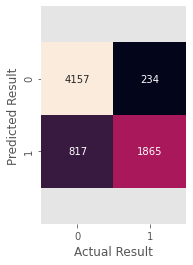

In [291]:
mat = confusion_matrix(y_pred_xgb,test_y_xgb)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [266]:
from sklearn.model_selection import GridSearchCV

In [332]:
paramGrid = {"max_depth" : [5,6,7,8,9,10]}
cv = 2

In [333]:
fit_params={"early_stopping_rounds":5, 
            "eval_metric" : "auc", 
            "eval_set" : [[val_X_xgb, val_y_xgb]]}

In [334]:
model = xgb.XGBRegressor(learning_rate= 0.05, 
                         verbosity=1,
                         objective='binary:logistic',
                         subsample = 0.7,
                         colsample_bytree = 0.7,
                         scale_pos_weight = 2.349911190053286,
                         random_state=1)

gridsearch = GridSearchCV(model, paramGrid, verbose=1,cv = 2,
                        n_jobs = -1)

gridsearch.fit(train_X_xgb, train_y_xgb, **fit_params)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.3min remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.0min finished


[0]	validation_0-auc:0.862506
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.883963
[2]	validation_0-auc:0.892269
[3]	validation_0-auc:0.899534
[4]	validation_0-auc:0.902337
[5]	validation_0-auc:0.905057
[6]	validation_0-auc:0.907803
[7]	validation_0-auc:0.908734
[8]	validation_0-auc:0.907833
[9]	validation_0-auc:0.9092
[10]	validation_0-auc:0.91059
[11]	validation_0-auc:0.911343
[12]	validation_0-auc:0.911638
[13]	validation_0-auc:0.91207
[14]	validation_0-auc:0.912862
[15]	validation_0-auc:0.913734
[16]	validation_0-auc:0.914234
[17]	validation_0-auc:0.91447
[18]	validation_0-auc:0.915312
[19]	validation_0-auc:0.91593
[20]	validation_0-auc:0.916336
[21]	validation_0-auc:0.917199
[22]	validation_0-auc:0.917462
[23]	validation_0-auc:0.917856
[24]	validation_0-auc:0.918561
[25]	validation_0-auc:0.918727
[26]	validation_0-auc:0.919605
[27]	validation_0-auc:0.920208
[28]	validation_0-auc:0.920403
[29]	validation_0-auc:0.921049
[30]	validation_0-auc:0

GridSearchCV(cv=2,
             estimator=XGBRegressor(colsample_bytree=0.7, learning_rate=0.05,
                                    objective='binary:logistic', random_state=1,
                                    scale_pos_weight=2.349911190053286,
                                    subsample=0.7),
             n_jobs=-1, param_grid={'max_depth': [5, 6, 7, 8, 9, 10]},
             verbose=1)

In [335]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)

0.5112642258986644
{'max_depth': 9}


In [336]:
model = xgb.XGBRegressor(learning_rate= 0.05, 
                         verbosity=1,
                         objective='binary:logistic',
                         subsample = 0.7,
                         colsample_bytree = 0.7,
                         scale_pos_weight = 2.349911190053286,
                         random_state=1,
                        max_depth = 5)
model.fit(train_X_xgb, train_y_xgb, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(val_X_xgb, val_y_xgb)])
y_pred_xgb = model.predict(test_X_xgb)

[0]	validation_0-auc:0.849186
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.878202
[2]	validation_0-auc:0.877414
[3]	validation_0-auc:0.880505
[4]	validation_0-auc:0.883067
[5]	validation_0-auc:0.885838
[6]	validation_0-auc:0.888724
[7]	validation_0-auc:0.890981
[8]	validation_0-auc:0.891121
[9]	validation_0-auc:0.892434
[10]	validation_0-auc:0.893584
[11]	validation_0-auc:0.894864
[12]	validation_0-auc:0.895439
[13]	validation_0-auc:0.895722
[14]	validation_0-auc:0.895696
[15]	validation_0-auc:0.89571
[16]	validation_0-auc:0.89603
[17]	validation_0-auc:0.897556
[18]	validation_0-auc:0.898382
[19]	validation_0-auc:0.898597
[20]	validation_0-auc:0.899176
[21]	validation_0-auc:0.899345
[22]	validation_0-auc:0.899867
[23]	validation_0-auc:0.899843
[24]	validation_0-auc:0.900845
[25]	validation_0-auc:0.901522
[26]	validation_0-auc:0.90233
[27]	validation_0-auc:0.90262
[28]	validation_0-auc:0.903502
[29]	validation_0-auc:0.904483
[30]	validation_0-au

In [337]:
y_pred_xgb_label = []
for i in y_pred_xgb:
    if i >= 0.5:
        label = 1
        y_pred_xgb_label.append(label)
    else:
        label = 0
        y_pred_xgb_label.append(label)


In [338]:
print(classification_report(test_y_xgb, y_pred_xgb_label,digits=4))

              precision    recall  f1-score   support

           0     0.9467    0.8357    0.8878      4974
           1     0.6954    0.8885    0.7802      2099

    accuracy                         0.8514      7073
   macro avg     0.8210    0.8621    0.8340      7073
weighted avg     0.8721    0.8514    0.8558      7073



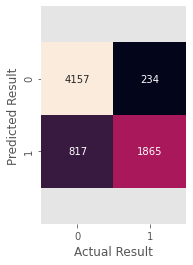

In [339]:
mat = confusion_matrix(y_pred_xgb_label,test_y_xgb)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [225]:
from xgboost import XGBClassifier
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [228]:
model = XGBClassifier()
eval_set = [(train_X_xgb, train_y_xgb), (test_X_xgb, test_y_xgb)]
model.fit(train_X_xgb, train_y_xgb, eval_metric=["error", "logloss",'auc'], eval_set=eval_set, verbose=False)

XGBClassifier()

In [229]:
y_pred = model.predict(test_X_xgb)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y_xgb, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
results = model.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

Accuracy: 84.59%


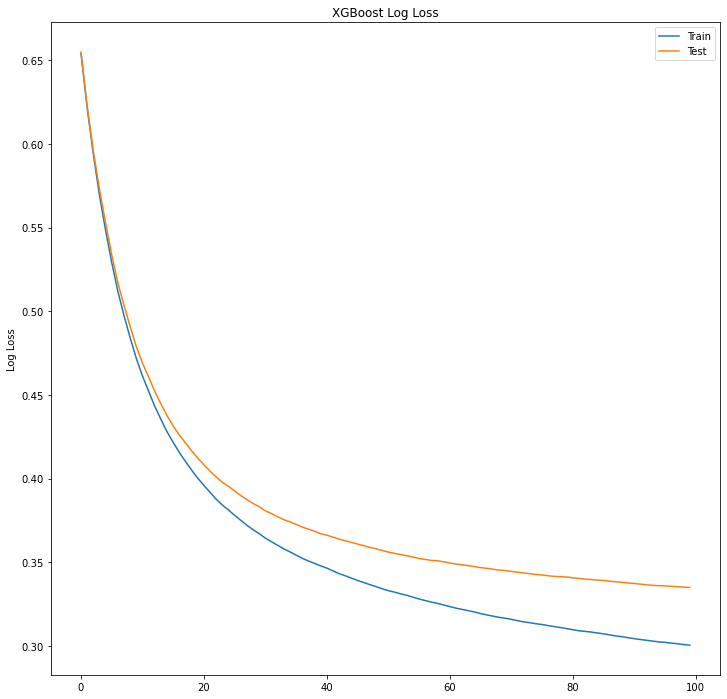

In [226]:
# plot log loss
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
pyplot.ylabel("Log Loss")
pyplot.title("XGBoost Log Loss")
pyplot.show()

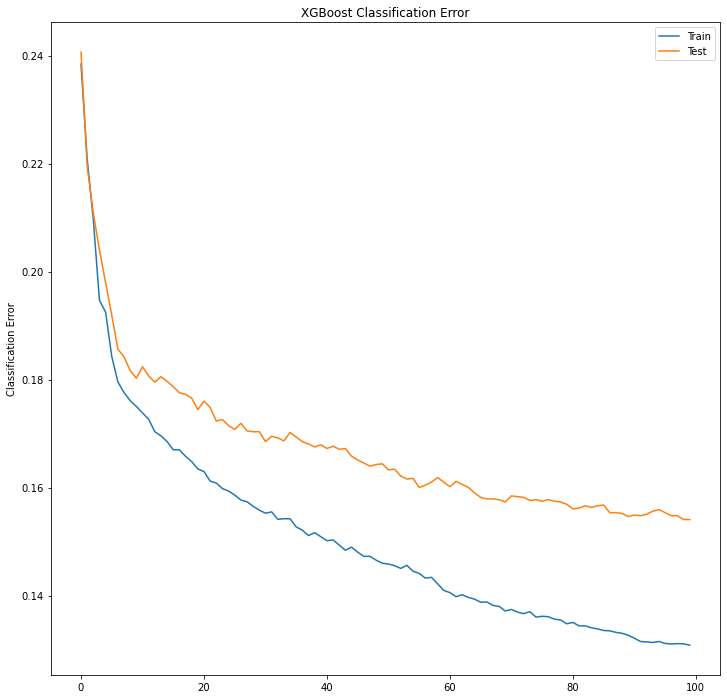

In [227]:
# plot classification error
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
pyplot.ylabel("Classification Error")
pyplot.title("XGBoost Classification Error")
pyplot.show()

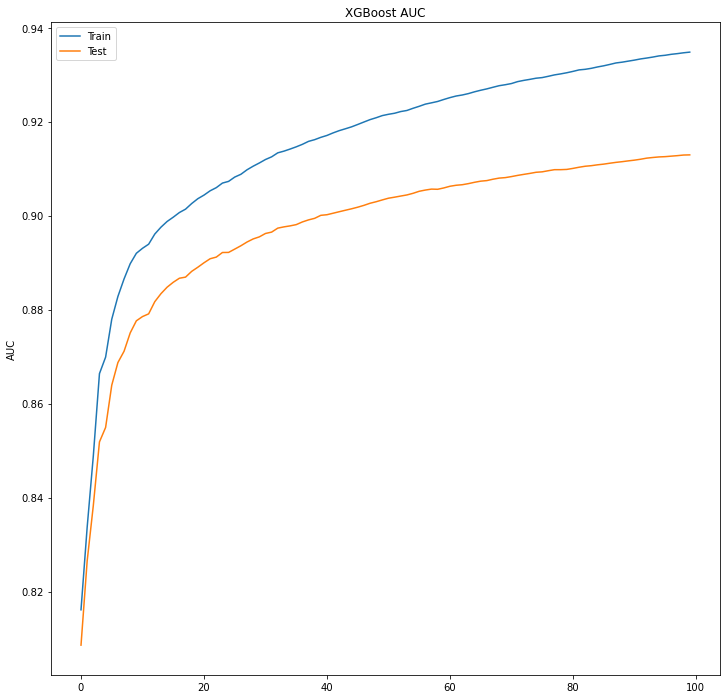

In [231]:
# plot log loss
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["auc"], label="Train")
ax.plot(x_axis, results["validation_1"]["auc"], label="Test")
ax.legend()
pyplot.ylabel("AUC")
pyplot.title("XGBoost AUC")
pyplot.show()

### Model 4.1: zhihu word vectors + cnn

#### 0.需要的库

In [ ]:
# 首先加载必用的库，jieba和gensim专门中文 
# %matplotlib inline功能是可以内嵌绘图，并且可以省略掉plt.show()这一步
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import re #正则化用
import jieba # 中文必须用【结巴分词】，因为计算机不会断句
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
#KeyedVectors实现实体（单词、文档、图片都可以）和向量之间的映射，实体都用string id表示
#有时候运行代码时会有很多warning输出，如提醒新版本之类的，如果不想乱糟糟的输出可以这样
import warnings
warnings.filterwarnings("ignore")

#### 1.预训练词向量

In [ ]:
cn_model = KeyedVectors.load_word2vec_format('sgns.zhihu.bigram', 
                                          binary=False)

#### 2.词向量模型

In [ ]:
# 由此可见每一个词都对应一个长度为300的向量
embedding_dim = cn_model['建筑'].shape[0]  #一词山东大学，shape[0]返回行数
print('词向量的长度为{}'.format(embedding_dim))
#cn_model['建筑']

In [ ]:
# 计算相似度
cn_model.similarity('伤亡', '事故')

In [ ]:
# dot（'橘子'/|'橘子'|， '橙子'/|'橙子'| ），余弦相似度
np.dot(cn_model['伤亡']/np.linalg.norm(cn_model['伤亡']), 
cn_model['事故']/np.linalg.norm(cn_model['事故']))

In [ ]:
# 找出最相近的词，余弦相似度
cn_model.most_similar(positive=['事故'], topn=10)

In [ ]:
# 找出不同的词
test_words = '事故 故障 爆炸事件 死亡 建筑'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

In [ ]:
cn_model.most_similar(positive=['建筑','事故'], negative=['工程'], topn=1)

#### 3.训练语料 （数据集）

In [ ]:
# 我们使用tensorflow的keras接口来建模
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional#Dense全连接
#Bidirectional双向LSTM  callbacks用来调参
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import models

In [ ]:
# 我们使用tensorflow的keras接口来建模
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional#Dense全连接
#Bidirectional双向LSTM  callbacks用来调参
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


#### 4.分词和tokenize

In [ ]:
train_tokens = newvalues['baidu_seg'].tolist()

In [ ]:
train_tokens = []
for row_idx in range(newvalues.shape[0]):
    cut_list = newvalues.loc[row_idx, 'baidu_seg'].copy()
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    train_tokens.append(cut_list)

In [ ]:
newvalues.loc[0, 'baidu_seg']

#### 5.索引长度标准化
因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，这样十分浪费计算资源，所以我们取一个折衷的长度。

In [ ]:
# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)


In [ ]:
# 平均tokens的长度
np.mean(num_tokens)

In [ ]:
# 最长的评价tokens的长度
np.max(num_tokens)

In [ ]:
plt.hist(np.log(num_tokens), bins = 100)#有大有小取对数
plt.xlim((3,6))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [ ]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

In [ ]:
# 取tokens的长度为1806时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens) / len(num_tokens)

#### 6.反向tokenize
为了之后来验证 我们定义一个function，用来把索引转换成可阅读的文本，这对于debug很重要。

In [ ]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text


In [ ]:
reverse = reverse_tokens(train_tokens[100])
reverse

In [ ]:
newvalues.loc[100, 'baidu_seg']

#### 7.构建embedding matrix
现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为(numwords, embeddingdim)的矩阵【num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，每一个词汇都用一个长度为300的向量表示】注意我们只选择使用前50k个使用频率最高的词，在这个预训练词向量模型中，一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

In [ ]:
# 只使用大库前50000个词
num_words = 100000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')


In [ ]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

In [ ]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

In [ ]:
train_tokens[0]

In [ ]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')


In [ ]:
len(train_pad[1])

In [ ]:
pd.DataFrame(train_pad[11]).shape

In [ ]:
# 超出9000个词向量的词用0代替
train_pad[train_pad >= num_words ] = 0

In [ ]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[1003]

In [ ]:
# pd.DataFrame(train_pad[10])[0].value_counts()
# 训练样本专业性很强，而预训练的词向量所用文本包含许多领域

In [ ]:
train_target = newvalues.label

In [ ]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split


In [ ]:
train_target.shape
train_pad.shape

In [ ]:
# 90%的样本用来训练，剩余10%用来测试
#因为前2000个文件夹都是neg一类，所以打乱顺序来训练 random_state
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12
                                                    )


In [ ]:
import random
X_train = random.sample(train_pad.tolist(), train_pad.shape[0]*0.7) # 结果['a', 'd', 'b', 'f', 'c']，每次运行结果不同。

In [ ]:
reverse = reverse_tokens(train_tokens[0])
reverse